# EOS Solver for TOV w/ DM

In [3]:
import numpy as np
from scipy import constants as c
import matplotlib.pyplot as plt 
from scipy import optimize
from scipy import integrate
from scipy import interpolate

In [88]:
# conversion from SI to NU

gev =  c.e * 1e9
nu_length = c.hbar * c.c /gev
nu_eps = gev / (nu_length**3)     # 1 GeV^4 = 1 nu_eps (2e37 Jm-3)
nu_mass = c.c**-2 * gev           # 1 GeV   = 1 nu_mass (1.8e-27 kg)
nu_time = c.hbar/gev              # 1 GeV-1 = 1 nu_time (6.58e-25 s)
nu_G = c.G / (nu_length**3 / (nu_mass * nu_time**2)) 

## (1) Baryonic EOS: 

### $$p_1=\frac{1}{3}(\epsilon_1-4B)$$

In [299]:
B = 0.145

eps_b = lambda p: 3*p + 4*(B**4)

In [317]:
## TOV - test for single component baryon:

def test_baryon(r, v):
    m, p = v
    e = eps_b(p)
    return [4*c.pi* r**2 * e, (-nu_G*m*e)/(r**2) * \
                 (1+(p/e)) * (1+((4*c.pi * r**3 * p)/(m))) / (1-((2*nu_G*m)/(r)))]

In [318]:
%%time

def boundary(r, v): return v[1]
boundary.terminal = True

R = []
M = []

for p0 in np.logspace(-14,3,1000):
    sol = integrate.solve_ivp(test_baryon, [1e-10,1e30], [1e-10,p0], dense_output=True, events=boundary,rtol=1e-5)
    R.append(sol.t_events[0][0])
    M.append(sol.y_events[0][0][0])


CPU times: user 6 s, sys: 14.7 ms, total: 6.02 s
Wall time: 6.04 s


[array([4.49248672e+19])] [array([[1.62440898e+57, 3.38813179e-20]])]


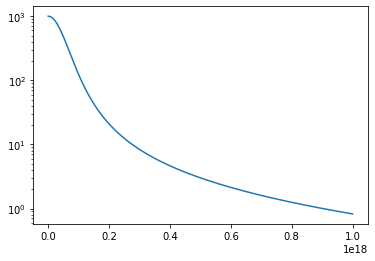

In [319]:
r = np.linspace(1e-10,1e18,500)
y = sol.sol(r)
plt.semilogy(r, y.T[:,1])
print(sol.t_events,sol.y_events)

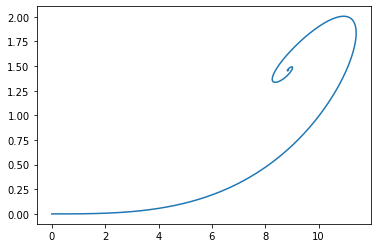

In [321]:
M_sun = 1.98840987e+30

plt.plot(np.divide(np.multiply(R,nu_length),1e3),np.divide(np.multiply(M,nu_mass),M_sun))

## (2) DM EOS:

In [339]:
mx = 100
y_coup = 0

eps_dm = lambda x: mx**4 * (((2*x**3+x)*np.sqrt(1+x**2)-np.arcsinh(x)) / (8* c.pi**2) \
                            + (y_coup**2 * x**6)/(9* c.pi**4) )

p_dm = lambda x: mx**4 * (((2*x**3-3*x)*np.sqrt(1+x**2)+3*np.arcsinh(x)) / (24* c.pi**2) \
                            + (y_coup**2 * x**6)/(9* c.pi**4) )

Text(0, 0.5, 'Energy density / GeV^4')

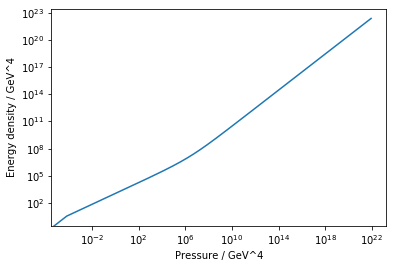

In [340]:
x_space = np.linspace(0,10000,1000001)
p_space = p_dm(x_space)     # y = 1000, m_DM = 100 GeV
e_space = eps_dm(x_space)

plt.loglog(p_space,e_space)
plt.xlabel('Pressure / GeV^4')
plt.ylabel('Energy density / GeV^4')

In [341]:
## TOV - test for single component dm:

f = interpolate.interp1d(p_space,e_space)

def p_to_e(p):
    
    if p<0:
        return 1e-40
    else:
        return f(p)

def test_dm(r, v):
    m, p = v
    e = p_to_e(p)
    return [4*c.pi* r**2 * e, (-nu_G*m*e)/(r**2) * \
                 (1+(p/e)) * (1+((4*c.pi * r**3 * p)/(m))) / (1-((2*nu_G*m)/(r)))]

In [345]:
%%time

def boundary(r, v): return (v[1]-1e-40)
boundary.terminal = True

R_dm = []
M_dm = []

for p0 in np.logspace(-14,3,500):
    sol = integrate.solve_ivp(test_dm, [1e-10,1e50], [1e-10,1], dense_output=True, events=boundary,rtol=1e-10)
    R_dm.append(sol.t_events[0][0])
    M_dm.append(sol.y_events[0][0][0])


CPU times: user 50.8 s, sys: 250 ms, total: 51.1 s
Wall time: 51.7 s


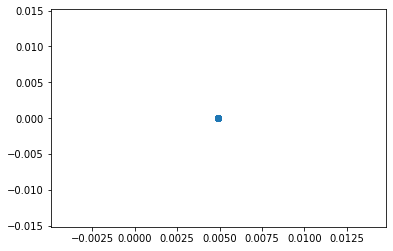

In [346]:
plt.scatter(np.divide(np.multiply(R_dm,nu_length),1e3),np.divide(np.multiply(M_dm,nu_mass),M_sun))

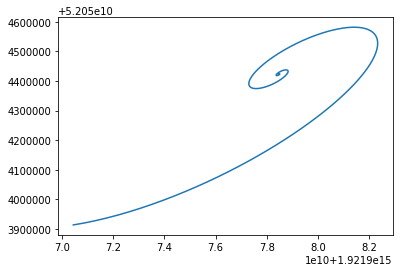

In [289]:
plt.plot(np.divide(np.multiply(R_dm,nu_length),1e3),np.divide(np.multiply(M_dm,nu_mass),M_sun))

[array([9.74006933e+33])] [array([[5.80623431e+67, 1.00000000e-40]])]


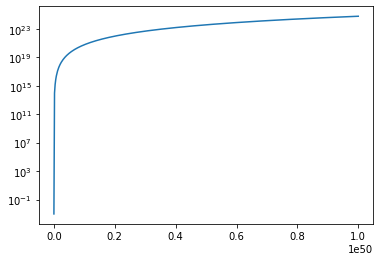

In [291]:
r = np.linspace(1e-10,1e50,500)
y = sol.sol(r)
plt.semilogy(r, y.T[:,1])
print(sol.t_events,sol.y_events)

## 2-component TOV Equation: 

### $$\frac{dp_i}{dr}=-\frac{Gm(r)}{r^2}\bigg[p_i(r)+\epsilon_i(r)\bigg]\bigg[1+\frac{4\pi r^3p(r)}{m(r)}\bigg]\bigg[1-\frac{2Gm(r)}{r}\bigg]^{-1} $$

## Mass Equation: 

### $$\frac{dm}{dr}=4\pi r^2 \epsilon(r)$$

In [304]:
# define neutron star differential equations
# 1: baryonic matter; 2: dark matter

def EOS(r, v):
    m1, m2, p1, p2 = v
    e1 = eps_b(p1)
    e2 = p_to_e(p2)
    return [4*c.pi* r**2 * e1, 4*c.pi* r**2 * e2, \
            (-nu_G*(m1+m2))/(r**2) * (p1+e1) * (1+((4*c.pi * r**3 * (p1+p2))/(m1+m2))) / (1-((2*nu_G*(m1+m2))/r)), \
            (-nu_G*(m1+m2))/(r**2) * (p2+e2) * (1+((4*c.pi * r**3 * (p1+p2))/(m1+m2))) / (1-((2*nu_G*(m1+m2))/r))  ]

In [311]:
%%time

def boundary_bm(r, v): return (v[2])
def boundary_dm(r, v): return (v[3]-1e-40)

boundary_bm.terminal = True

R_bm = []
M_bm = []
R_dm = []
M_dm = []

for p0 in np.logspace(-20,20,500):
    sol = integrate.solve_ivp(EOS, [1e-10,1e50], [1e-10,1e-10,p0,p0], dense_output=True, events=(boundary_bm,boundary_dm),rtol=1e-10)
    R_bm.append(sol.t_events[0][0])
    M_bm.append(sol.y_events[0][0][0])



CPU times: user 1min 17s, sys: 234 ms, total: 1min 17s
Wall time: 1min 17s


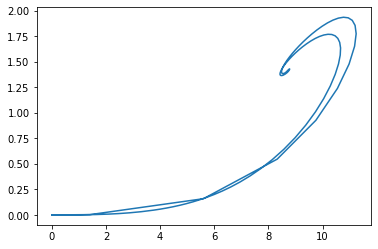

In [314]:
plt.plot(np.divide(np.multiply(R_bm,nu_length),1e3),np.divide(np.multiply(M_bm,nu_mass),M_sun))

In [316]:
sol.y_events

[array([[ 1.37900069e+46,  4.42644184e+51, -1.11808349e-19,
          2.10099864e+08]]),
 array([], dtype=float64)]

In [310]:
sol.t_events

[array([1.18773647e+14]), array([], dtype=float64)]